In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
path_to_dataset = "/fastdata/vilab24/meta-album"

# Confidence Estimation

In [32]:
import pathlib
import cdmetadl

PROJECT_DIR = pathlib.Path(cdmetadl.__file__).parent.parent

In [33]:
import pathlib

import cdmetadl.helpers.general_helpers
import cdmetadl.dataset

dataset_path = pathlib.Path(path_to_dataset)
dataset_info_dict = cdmetadl.helpers.general_helpers.check_datasets(dataset_path, ["AWA"])

dataset = cdmetadl.dataset.ImageDataset("-", dataset_info_dict["AWA"])

In [34]:
import cdmetadl.samplers

n_way_sampler = cdmetadl.samplers.ValueSampler(value=5)
k_shot_sampler = cdmetadl.samplers.ValueSampler(value=4)

task = dataset.generate_task(n_way_sampler, k_shot_sampler, query_size=4)

In [35]:
import cdmetadl.helpers.general_helpers

model_module = cdmetadl.helpers.general_helpers.load_module_from_path(PROJECT_DIR / "baselines/finetuning/model.py")
learner = model_module.MyLearner()
learner.load("/fastdata/vilab24/output/final/training/dropout_20_k_5/finetuning/cross-domain/model")

## Pseudo Confidence Estimation

[0.21189025044441223, 0.75815284, 0.0, 0.21410271525382996, 0.508541]


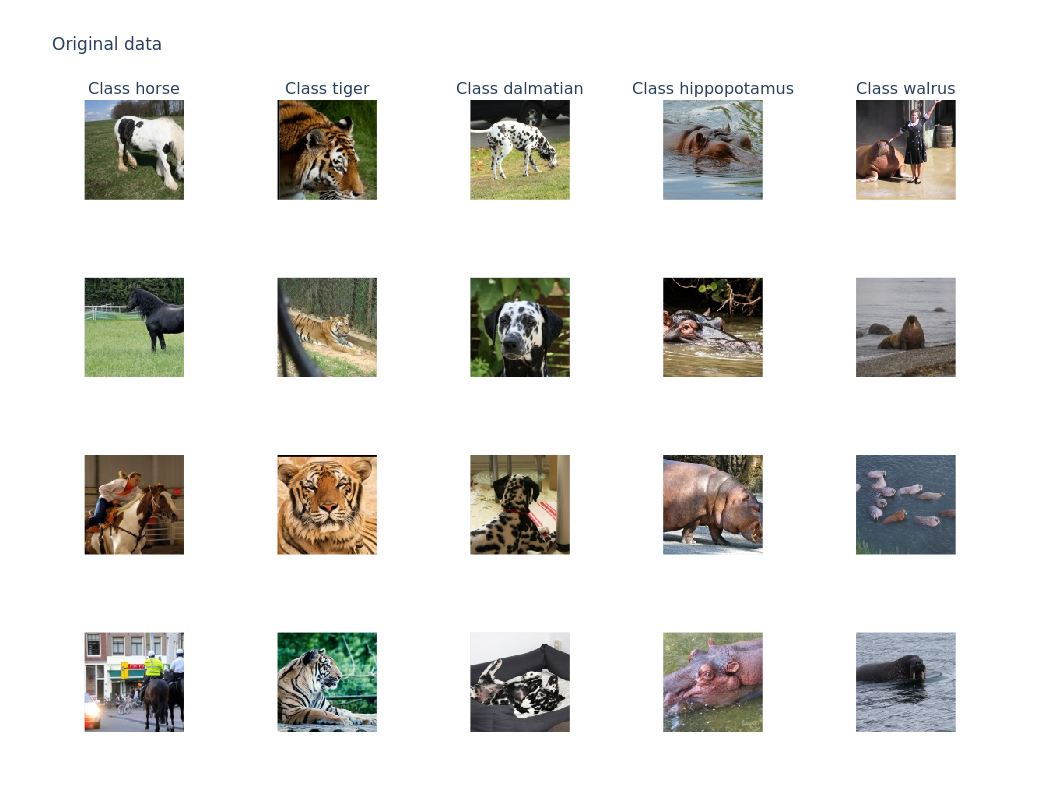

In [36]:
import cdmetadl.confidence
import cdmetadl.notebooks.helpers

confidence_estimator = cdmetadl.confidence.PseudoConfidenceEstimator()
_, confidence_scores = confidence_estimator.estimate(learner, task.support_set)
print(confidence_scores)

fig = cdmetadl.notebooks.helpers.show_images_grid_plotly(task.support_set, True)

# [0.0, 0.18486230075359344, 0.24935679137706757, 0.6171985, 0.65151805]
# [0.0, 0.22809550166130066, 0.0, 0.61176157, 0.6571647]
# [0.0, 0.373231, 0.24391575157642365, 0.6873157, 0.6825583]
# [0.0, 0.26143714785575867, 0.25179627537727356, 0.6620778, 0.66274285]


## Monte Carlo Dropout Confidence Estimation

In [37]:
import cdmetadl.confidence
import cdmetadl.notebooks.helpers

confidence_estimator = cdmetadl.confidence.MCDropoutConfidenceEstimator(num_samples=1000)

In [38]:
_, confidence_scores = confidence_estimator.estimate(learner, task.support_set)

#fig = cdmetadl.notebooks.helpers.show_images_grid_plotly(task.support_set, True)

print(confidence_scores)

[0.0, 0.7452122569084167, 0.32152891159057617, 1.0, 0.36681419610977173]


In [48]:
from tqdm import tqdm
import numpy as np

learner.T = 2_000
samples_conf_scores = 10
conf_scores = np.array([confidence_estimator.estimate(learner, task.support_set)[1] for _ in tqdm(range(samples_conf_scores))])

correlation_between_conf_scores = np.corrcoef(conf_scores)

avg_correlation = (sum(np.corrcoef(conf_scores).flatten()) - samples_conf_scores)/(samples_conf_scores**2 - samples_conf_scores)
avg_correlation

# correlation for T=500: 0.9314140250282017, given just np.mean(class_predictions.var(axis=0), axis=0)
# correlation for T=100: 0.8434363560621483, given just np.mean(class_predictions.var(axis=0), axis=0)
# correlation for T=10: 0.21393220334108354, given just np.mean(class_predictions.var(axis=0), axis=0)
# correlation for T=1: 0.010913240886573989, given just np.mean(class_predictions.var(axis=0), axis=0)
# correlation for T=1: -0.033874643193452826, given just np.mean(class_predictions.var(axis=0), axis=0)


# correlation for T=500: 0.9456434617296655, old transformation x_min and x_max estimated from data
# correlation for T=100: 0.8768065080765797, old transformation x_min and x_max estimated from data
# correlation for T=10: 0.12096007880679242, old transformation x_min and x_max estimated from data



100%|██████████| 10/10 [04:48<00:00, 28.80s/it]


0.9630452504173093

In [49]:
import pandas as pd

pd.Series(conf_scores.argmax(axis=1)).value_counts()

1    10
Name: count, dtype: int64

In [50]:
pd.Series(conf_scores.argmin(axis=1)).value_counts()

3    10
Name: count, dtype: int64

In [51]:
pd.DataFrame(conf_scores).rank(axis=1).mean()

0    3.0
1    5.0
2    2.0
3    1.0
4    4.0
dtype: float64

In [52]:
pd.DataFrame(conf_scores).describe()

,0,1,2,3,4
count,10.000000,10.0,10.000000,10.0,10.000000
mean,0.559714,1.0,0.286538,0.0,0.723048
std,0.145787,0.0,0.145021,0.0,0.100302
min,0.270746,1.0,0.011049,0.0,0.511745
25%,0.497516,1.0,0.239427,0.0,0.687643
50%,0.567050,1.0,0.360496,0.0,0.728816
75%,0.692482,1.0,0.389497,0.0,0.780276
max,0.705973,1.0,0.402891,0.0,0.875525


In [54]:
conf_scores

array([[0.70246148, 1.        , 0.40091205, 0.        , 0.73298365],
       [0.27074581, 1.        , 0.01104891, 0.        , 0.51174527],
       [0.70597297, 1.        , 0.40289062, 0.        , 0.87552468],
       [0.49327046, 1.        , 0.3742044 , 0.        , 0.69837916],
       [0.66254416, 1.        , 0.34678823, 0.        , 0.79604028],
       [0.41234672, 1.        , 0.05862719, 0.        , 0.68406475],
       [0.51454422, 1.        , 0.2688843 , 0.        , 0.65154827],
       [0.61955541, 1.        , 0.37962925, 0.        , 0.7265057 ],
       [0.70545107, 1.        , 0.39278626, 0.        , 0.82256162],
       [0.51025236, 1.        , 0.2296083 , 0.        , 0.73112583]])

In [53]:
pd.DataFrame(conf_scores)

,0,1,2,3,4
0,0.702461,1.0,0.400912,0.0,0.732984
1,0.270746,1.0,0.011049,0.0,0.511745
2,0.705973,1.0,0.402891,0.0,0.875525
3,0.493270,1.0,0.374204,0.0,0.698379
4,0.662544,1.0,0.346788,0.0,0.796040
5,0.412347,1.0,0.058627,0.0,0.684065
6,0.514544,1.0,0.268884,0.0,0.651548
7,0.619555,1.0,0.379629,0.0,0.726506
8,0.705451,1.0,0.392786,0.0,0.822562
9,0.510252,1.0,0.229608,0.0,0.731126
